# Углубление в PyTorch. Пример нейронной сети на MNIST

Источник:

[[doc] 🛠️ Learn the basics tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html)

## Dataset и DataLoader

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L05/out/dataset_dataloader.png" width="1000"></center>

Предварительная обработка данных часто сильно зависит от домена, предметной области, самих данных. В идеале мы бы хотели, чтобы код, относящийся к набору данных, был отделен от кода для обучения модели для его лучшей читаемости, понимаемости и модульности.

PyTorch предоставляет два базовых класса для работы с данными: `torch.utils.data.DataLoader` и `torch.utils.data.Dataset`, которые позволяют работать как со встроенными наборами данных, так и с вашими собственными данными.

`Dataset` хранит в себе объекты (samples, сэмплы) — например, изображения и соответствующие им метки (labels, targets).

`DataLoader` представляет из себя итерируемый объект — обертку над `Dataset`-ом, и позволяет получить простой доступ к объектам и меткам из набора данных в виде мини-батчей.

Библиотеки из семейства PyTorch предоставляют ряд предзагруженных наборов данных (например, таких как MNIST), которые релизованы как дочерние классы от `torch.utils.data.Dataset` и несут в себе функции, специфичные для конкретных данных. Эти наборы данных могут быть использованы как бенчмарк для отладки и оценки вашей модели или в учебных целях. Вы можете найти их здесь:
* [[doc] 🛠️ Image Datasets](https://pytorch.org/vision/stable/datasets.html),
* [[doc] 🛠️ Text Datasets](https://pytorch.org/text/stable/datasets.html),
* [[doc] 🛠️ Audio Datasets](https://pytorch.org/audio/stable/datasets.html).

### Загрузка набора данных

Рассмотрим пример того, как загрузить набор данных MNIST, который содержится в `torchvision.datasets` [🛠️[doc]](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

Загрузим MNIST, указав следующие параметры:
* `root` — путь до директории с данными,
* `train` определяет, использовать обучающую или тестовую часть набора данных,
* `download=True` позволяет скачать данные из интернета, если их нет в пути `root`,
*  `transform` определяет преобразования, которые нужно сделать с данными. Здесь мы сразу указываем `transform=ToTensor()`, чтобы перевести входные данные (изображения) в формат `torch.Tensor`. Подробнее о трансформациях поговорим далее.

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from IPython.display import clear_output

train_data = datasets.MNIST(
    root="./MNIST", train=True, download=True, transform=ToTensor()
)

test_data = datasets.MNIST(
    root="./MNIST", train=False, download=True, transform=ToTensor()
)

clear_output()

print("Train data info:\n", train_data)
print("\nTest data info:\n", test_data)

Train data info:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data info:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./MNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


Чтобы дальнейший код воспроизводился, зафиксируем случайные состояния:

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

### Разделение выборки на обучающую и валидационную

Выделим из обучающей выборки часть данных для **валидации** при помощи функции `random_split` [🛠️[doc]](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) из модуля `torch.utils.data`.

Сумма значений в параметре `lengths` функции `random_split` должна в точности равняться количеству элементов в датасете, который она разделяет.

In [ ]:
from torch.utils.data import random_split

train_data, val_data = random_split(train_data, lengths=[50000, 10000])

Функция `random_split` возвращает объекты класса `Subset`. Эти объекты имеют два основных атрибута:

* `dataset` — объект, из которого данный Subset был выделен, он будет один и тот же для всех продуктов функции `random_split`,
* `indices` — список индексов, которые попали в данный Subset.



In [ ]:
print(f"Type of train_data: {type(train_data)}")
print(f"Type of val_data:   {type(val_data)}\n")

print(f"Type of train_data.dataset: {type(train_data.dataset)}")
print(f"Type of val_data.dataset:   {type(val_data.dataset)}\n")


print(
    f"train_data.dataset and val_data.dataset are same: {train_data.dataset is val_data.dataset}\n"
)

print(f"First 10 indices of train_data: {train_data.indices[:10]}")
print(f"First 10 indices of val_data:   {val_data.indices[:10]}")

Type of train_data: <class 'torch.utils.data.dataset.Subset'>
Type of val_data:   <class 'torch.utils.data.dataset.Subset'>

Type of train_data.dataset: <class 'torchvision.datasets.mnist.MNIST'>
Type of val_data.dataset:   <class 'torchvision.datasets.mnist.MNIST'>

train_data.dataset and val_data.dataset are same: True

First 10 indices of train_data: [37542, 43087, 2992, 25810, 39634, 6425, 55768, 11034, 44310, 44384]
First 10 indices of val_data:   [59753, 9414, 10988, 15501, 49861, 36839, 28752, 18201, 14976, 32202]


### Итерирование по `Dataset` и визуализация данных

Можно обращаться к элементам `Dataset`-а вручную, как в списках или массивах: `dataset[i]`. При таком обращении мы получим кортеж `(sample, label)`. Воспользуемся библиотекой matplotlib, чтобы отобразить первые 10 изображений из тестового множества.

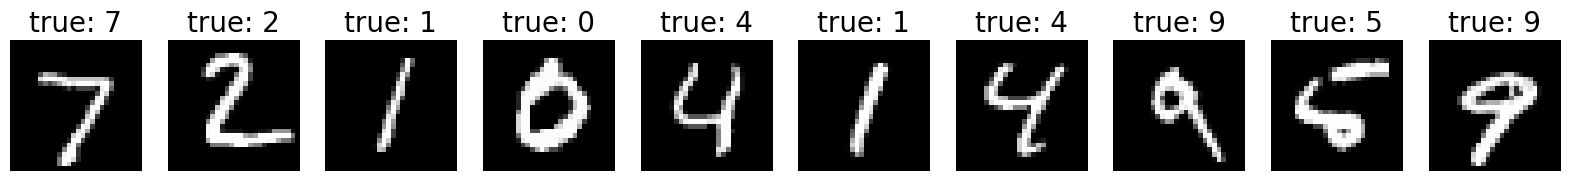

In [ ]:
import matplotlib.pyplot as plt

num_imgs_to_visualize = 10

figure = plt.figure(figsize=(20, 20))

for i in range(num_imgs_to_visualize):
    # here we indexing the Dataset-object "as is" and gettig a tuple (img, label)
    img, label = test_data[i]

    figure.add_subplot(1, num_imgs_to_visualize, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"true: {label}", fontsize=20)
    plt.axis("off")
plt.show()

### Подготовка данных для обучения с помощью DataLoader

`Dataset` возвращает по одной паре "объект — метка" за раз. При обучении моделей мы обычно хотим получать обекты в виде мини-батчей, перемешивая данные на каждой эпохе для уменьшения переобучения.

`DataLoader` — это объект, который позволяет нам получать такие мини-батчи. При инициализации он принимает в себя объект `Dataset` (или `Subset`), а также параметры `batch_size` (размер мини-батча) и `shuffle` (перемешивать ли данные в батчах каждую эпоху).

Другие параметры, а также значения по умолчанию можно посмотреть в документации PyTorch для класса `DataLoader` [🛠️[doc]](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

Так как мы разделили данные на обучающие, валидационные и тестовые (`train_data`, `val_data` и `test_data`), то мы создаем также три независимых `DataLoader`-а. Один из них позволит нам получать батчи из обучающей выборки, второй — из валидационной, третий — из тестовой.

Обратите внимание на параметр `shuffle`! По умолчанию он имеет значение `False`. **Для обучения нейронной сети критически важно, чтобы во время обучения батчи обучающих данных перемешивались**. Именно таким образом мы вносим **стохастичность** в процесс градиентного спуска. Поэтому для `DataLoader`-a, который будет выдавать батчи для обучения, необходимо использовать `shuffle=True`.

В противоположность этому — `DataLoader`-ы для валидационных и тестовых данных. Эти данные данные служат для оценки качества работы модели, на них не происходит обучение и градиентный спуск. Поэтому установка здесь `shuffle=True` не имеет большого смысла.

#### Итерирование по `DataLoader`

Мы загрузили набор данных в `DataLoader`, и теперь можем проходиться по нему по мере необходимости. Каждая итерация в коде ниже будет возвращать мини-батч в виде кортежа тензоров `(samples, labels)`, содержащих `batch_size=8` объектов и меток соответственно.
Так как мы установили для `train_dataloader` параметр `shuffle=True`, когда мы пройдемся по всем батчам, данные перемешаются.

Images batch shape: torch.Size([8, 1, 28, 28]) : [batch_size, num_channels, H, W]
Labels batch shape: torch.Size([8])

The first sample in the batch:


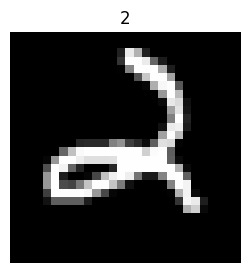

In [ ]:
# get one next batch
imgs, labels = next(iter(train_dataloader))

print(f"Images batch shape: {imgs.size()} : [batch_size, num_channels, H, W]")
print(f"Labels batch shape: {labels.size()}")

print("\nThe first sample in the batch:")
img = imgs[0].squeeze()
label = labels[0].item()

plt.figure(figsize=(3, 3))
plt.imshow(img, cmap="gray")
plt.title(label)
plt.axis("off")
plt.show()

#### Взвешенное формирование батчей для работы с дисбалансом

Еще одним атрибутом `DataLoader` является `sampler` [🛠️[doc]](https://pytorch.org/docs/stable/data.html#torch.utils.data.Sampler) — он отвечает за то, как объекты набираются в батчи. **По умолчанию** все объекты могут попадать в батчи **равновероятно**.

При работе с несбалансированными классами можно формировать батчи так, чтобы в каждом батче примерно был баланс классов.

Это может улучшать сходимость даже в случае небольшого дисбаланса или его отсутствия, т. к. мы будем избегать шаги обучения нейросети, в которых она просто не увидела какого-то класса в силу случайных причин.


<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L05/out/batch_balancing.png" width="1000"></center>

При таком подходе требуется, чтобы объекты попадали в батчи **не равновероятно, а с определенными весами**. В PyTorch эту функциональность можно получить, используя класс `WeightedRandomSampler` [🛠️[doc]](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler). Для его инициализации требуется рассчитать вес каждого класса.

Сумма весов не обязана быть равна единице, важно только соотношение между весами. Часто соотношение весов делают обратно пропорциональным количеству объектов в классах.



```python
_, classes_counts = torch.unique(y, return_counts=True)  # y — tensor of labels in train set
weights_for_classes = classes_counts.max() / classes_counts
```

В конструктор `WeightedRandomSampler` требуется подать два аргумента:

- список весов для **каждого** элемента в датасете;
- количество элементов (можно использовать не весь датасет).

Затем созданный `sampler` передается в конструктор `DataLoader`.

```python
from torch.utils.data import WeightedRandomSampler

weight_for_every_sample = []  # Every sample must have a weight
for label in y:
    weight_for_every_sample.append(weights_for_classes[label].item())

sampler = WeightedRandomSampler(torch.tensor(weight_for_every_sample), len(dataset))
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
```

Когда у `DataLoader` указывается `sampler`, последний принимает на себя функцию перемешивания, поэтому параметр `shuffle` **должен** быть не указан.

Также отметим, что подобную процедуру взвешенного формирования батчей следует производить только с обучающими данными, но не с валидационными и тестовыми. Мы хотим, чтобы модель при обучении поровну видела объекты всех классов, но оценивать качество нужно на данных с реальным распределением.

Стоит отметить, что нужно быть осторожным со взвешиванием объектов в батчах и **контролировать состав батчей**. Дело в том, что при существенном дисбалансе веса при объектах минорного класса могут оказываться на несколько порядков больше, чем при объектах мажорного класса. Данные веса преобразуются в вероятности для сэмплирования, и может случиться так, что вероятности при объектах мажорного класса станут численно неотличимы от нуля. Тем самым можно получить обратный эффект: батчи будут состоять исключительно из объектов минорного класса. В таком случае нужно намеренно ограничивать веса.

## Трансформации (Transforms)

Данные не всегда поступают в том формате, который требуется для работы моделей машинного обучения. Для того, чтобы производить некоторые преобразования с данными, чтобы они становились пригодны для обучения, в PyTorch реализован механизм трансформаций (transforms).

Все наборы данных в Torchvision имеют два параметра: `transform` — для применения трансформаций к входным данным, и `target_transform` — соответственно для преобразования меток.
Эти параметры принимают в себя вызываемые (callable) объекты, содержащие логику преобразований. Модуль `torchvision.transforms` [🛠️[doc]](https://pytorch.org/vision/stable/transforms.html) предоставляет ряд часто используемых трансформаций "из коробки".

Важно понимать, что трансформации, указанные в `transform` и `target_transform`, **применяются к данным налету**, то есть в момент обращения к этим данным через `Dataset` или `DataLoader`.

### ToTensor

Изображения в MNIST (и в большинстве других встроенных датасетов) изначально хранятся в формате PIL Image (Python Image Library), а метки представлены как целые числа. Если с метками, представленными таким образом, ничего делать не нужно, то входные данные для обучения необходимо перевести в тензоры. Чтобы произвести эту трансформацию, выше при загрузке данных MNIST мы использовали `torchvision.transforms.ToTensor` [🛠️[doc]](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

`ToTensor` преобразует PIL Image или NumPy `ndarray` в `FloatTensor` **и масштабирует значения интенсивности пикселей к диапазону $[0., 1.]$**.

### Normalize

Предположим, что помимо перевода данных в подходящий формат мы бы хотели произвести какие-то преобразования с самими величинами. Скажем, произвести нормализацию: вычесть математическое ожидание и разделить на стандартное отклонение по выборке. Для проведения такой операции в `torchvision.transforms` предусмотрена трансформация `Normalize` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html).

Два обязательных параметра в этой трансформации — это `mean` и `std`:
* `mean` — последовательность математических ожиданий по каждому каналу выборки изображений,
* `std` — последовательность стандартных отклонений по каждому каналу выборки изображений.

`Normalize` не применяется к PIL Image, поэтому ее необходимо применять после `ToTensor`.

Давайте вычислим среднее и стандартное отклонение по обучающим данным. Для этого обратимся к `train_data.dataset.data` по индексам, которые попали в Subset `train_data`:

In [ ]:
import torch

raw_train_data = train_data.dataset.data[train_data.indices]

print("Train part of data:")
print("Type: ", type(raw_train_data))
print("Size: ", raw_train_data.size())
print("Dtype:", raw_train_data.dtype)
print("Max:  ", torch.max(raw_train_data).item())
print("Min:  ", torch.min(raw_train_data).item())

Train part of data:
Type:  <class 'torch.Tensor'>
Size:  torch.Size([50000, 28, 28])
Dtype: torch.uint8
Max:   255
Min:   0


В `train_data.dataset.data` для MNIST данные хранятся как тензор целых чисел (`uint8`) c минимальным значением $0$ и максимальным значением $255$. Функции `torch.mean()` и `torch.std()` выдадут ошибку, если передать им тензор целых чисел. Поэтому изменим тип на вещественный, применив метод `.double()`.

In [ ]:
mean = torch.mean(raw_train_data.double()).item()
std = torch.std(raw_train_data.double()).item()
print(f"mean = {mean:.2f}, std = {std:.2f}")

mean = 33.33, std = 78.58


Вспомним, что `Normalize` должна применяться после `ToTensor`, которая масштабирует величины в диапазон $[0., 1.]$. Значит, матожидание и стандартное отклонение мы также должны разделить на максимальное значение до масштабирования — на $255$.

In [ ]:
mean /= 255
std /= 255
print(f"Scaled mean = {mean:.2f}, std = {std:.2f}")

Scaled mean = 0.13, std = 0.31


### Compose

Мы вычислили среднее и стандартное отклонение по обучающей выборке MNIST для применения транcформации `Normalize`. Но мы также помним, что она должна применяться только после `ToTensor`. Как же объединить несколько трансформаций в одну, чтобы они применились последовательно?

Для этого предусмотрен класс `torchvision.transforms.Compose` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html). Его единственный параметр — список принимаемых трансформаций. `Compose` — это контейнер для трансформаций, при помещении в который они будут применяться одна за одной. В общем случае их может быть сколько угодно. Давайте напишем трансформацию, которая примет в себя две: `ToTensor` и `Normalize`.

In [ ]:
from torchvision import transforms

transform_with_normalize = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

print(transform_with_normalize)

Compose(
    ToTensor()
    Normalize(mean=0.13071035334133654, std=0.30815512051891786)
)


Остается только подменить у обучающего и тестового датасетов ту трансформацию, которую мы указали при загрузке данных, на нашу новую — с нормализацией. Для этого посмотрим на атрибут `.transform` и изменим его.

**Внимание! Неочевидная особенность!**

Функция `random_split` возвращает объекты класса `Subset`, которые не имеют своих трансформаций, а используют трансформации, определенные в родительском объекте класса `Dataset`.

In [ ]:
print("Old train and val transform:", train_data.dataset.transform)
print("Old test transform:", test_data.transform)

train_data.dataset.transform = transform_with_normalize
test_data.transform = transform_with_normalize

print("\nNew train and val transform:", train_data.dataset.transform)
print("New test transform:", test_data.transform)

Old train and val transform: ToTensor()
Old test transform: ToTensor()

New train and val transform: Compose(
    ToTensor()
    Normalize(mean=0.13071035334133654, std=0.30815512051891786)
)
New test transform: Compose(
    ToTensor()
    Normalize(mean=0.13071035334133654, std=0.30815512051891786)
)


Следует еще раз заметить, что при нормализации мы **вычисляем** оценки математического ожидания и стандартного отклонения `mean` и `std` **на обучающих данных**, а **применяем** вычисленные оценки **и на обучающих, и на валидационных, и на тестовых данных**.

Теперь при обращении к данным через `DataLoader` будет происходить следующее:

1. Объект `DataLoader` обращается к объекту `Dataset` за данными, чтобы сформировать батч.
2. `Dataset` считывает данные, которые хранятся на диске, в формате PIL Image, применяет к ним трансформации, указанные в его атрибуте `.transform` (в данном случае это последовательность `ToTensor` и `Normalize`) и возвращает `DataLoader`-у преобразованные данные.
3. `DataLoader` формирует из полученных данных батч и возвращает его.

Обратите внимание, что на диске по-прежнему лежат просто изображения в своем специальном формате, и их довольно много. Но при этом в каждый момент времени мы не храним на диске все изображения как тензоры в сыром виде или в нормализованном. Нужные операции применяются к данным налету, только когда они нужны — при формировании батчей.

## Создание нейронной сети

Нейронные сети состоят из слоев, которые производят преобразования над данными. В PyTorch принято называть слои ***модулями*** (modules), и далее мы тоже будем использовать это название.

Пространство имен `torch.nn` [🛠️[doc]](https://pytorch.org/docs/stable/nn.html) предоставляет "строительные блоки", которые нужны для создания своей собственной нейронной сети. Каждый *модуль* в PyTorch является дочерним классом от `nn.Module` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Таким образом, нейронная сеть сама по себе будет являться *модулем*, состоящим из других *модулей* (слоев). Такая вложенная структура позволяет легко создавать сложные архитектуры и управлять ими.

Ниже мы рассмотрим пример создания нейронной сети для классификации изображений из набора данных MNIST.

### Выбор устройства (device) для обучения

Мы бы хотели иметь возможность обучать модель на аппаратном ускорителе, таком как GPU, если он доступен. Проверим, доступен ли нам ускоритель `torch.cuda` [🛠️[doc]](https://pytorch.org/docs/stable/notes/cuda.html), иначе продолжим вычисления на CPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Описание класса модели

Мы определяем нейронную сеть, наследуясь от класса `nn.Module`, и инициализируем ее слои в методе `__init__`. Каждый класс-наследник `nn.Module` производит операции над входными данными в методе `forward`.

Напишем собственную нейронную сеть как класс `NeuralNetwork`. Ниже подробно рассмотрим все составляющие ее части.

In [ ]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

Создадим экземпляр класса `NeuralNetwork`, переместим его на `device` с помощью метода `to` и выведем информацию о структуре модели:

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


Чтобы использовать модель, мы передаем ей входные данные. Это приводит в действие метод `forward`, а также определенные фоновые операции. Не следует вызывать `model.forward` напрямую!

Вызов модели с входными данными возвращает тензор с двумя размерностями: нулевая размерность `dim=0` соответствует  количеству переданных примеров, а первая `dim=1` — десяти выходным "сырым" предсказаниям (логитам) для каждого класса.

Мы можем получить предсказание модели в виде вероятностей, пропустив логиты через экземпляр модуля `nn.Softmax`, вызвав его вычисление вдоль первой размерности `dim=1`.

In [ ]:
# random input of 3 images
sample_batch = torch.rand(
    3, 1, 28, 28, device=device
)  # [batch_size, num_channels, H, W]

# model output
logits = model(sample_batch)

# predicted probabilities
pred_probab = nn.Softmax(dim=1)(logits)

# predicted classes
y_pred = pred_probab.argmax(dim=1)

print(f"Input size:       {sample_batch.size()} : [batch_size, num_channels, H, W]")
print(f"Output size:      {logits.size()}        : [batch_size, num_classes]")
print(
    f"Predicted class:  {y_pred}          : [class for sample 1, class for sample 2, class for sample 3]"
)

Input size:       torch.Size([3, 1, 28, 28]) : [batch_size, num_channels, H, W]
Output size:      torch.Size([3, 10])        : [batch_size, num_classes]
Predicted class:  tensor([3, 3, 3])          : [class for sample 1, class for sample 2, class for sample 3]


### Слои модели

Давайте заглянем "под капот" нашей модели `NeuralNetwork`. Для иллюстрации возьмем мини-батч из трех одноканальных изображений $28×28$ и посмотрим, что с ним происходит, когда мы пропускаем его через сеть.

In [ ]:
sample_batch = torch.rand(3, 1, 28, 28)
print(f"Input size: {sample_batch.size()}")

Input size: torch.Size([3, 1, 28, 28])


#### Слой `nn.Flatten`

Мы используем слой `nn.Flatten` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) для преобразования каждого изображения $1×28×28$ пикселей в непрерывный массив из $784$ значений (размер батча (на позиции `dim=0`) сохраняется).

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(sample_batch)
print(f"Size after Flatten: {flat_image.size()}")

Size after Flatten: torch.Size([3, 784])


#### Слой `nn.Linear`

Линейный слой `nn.Linear` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) — это модуль, который производит линейное преобразование входных данных с помощью хранящихся в нем весов и смещений.

Обязательными параметрами при объявлении этого слоя являются `in_features` — количество входных признаков, и `out_features` — количество выходных признаков.

Фактически этот модуль добавляет в модель один полносвязный слой нейронов *без активаций*. Слой состоит из `out_features` нейронов, каждый из которых имеет `in_features` входов.

В примере ниже мы объявляем слой из $512$ нейронов, каждый из которых получает "вытянутое" изображение из $784$ пикселей.

In [ ]:
layer1 = nn.Linear(in_features=784, out_features=512)
hidden1 = layer1(flat_image)
print(f"Size after Linear:  {hidden1.size()}")

Size after Linear:  torch.Size([3, 512])


Линейный слой, в отличие от слоя `nn.Flatten`, имеет обучаемые параметры — веса и смещения. Они хранятся как объекты специального класса `torch.nn.parameter.Parameter` и содержат в себе тензоры собственно с величинами параметров. Получить доступ к ним можно, обратившись к атрибутам слоя `.weight` и `.bias` соответственно.

In [ ]:
print(f"Size of linear layer weights: {layer1.weight.size()}")
print(f"Type of linear layer weights: {type(layer1.weight)}")

print(f"\nSize of linear layer biases: {layer1.bias.size()}")
print(f"Type of linear layer biases: {type(layer1.bias)}")

Size of linear layer weights: torch.Size([512, 784])
Type of linear layer weights: <class 'torch.nn.parameter.Parameter'>

Size of linear layer biases: torch.Size([512])
Type of linear layer biases: <class 'torch.nn.parameter.Parameter'>


#### Слой `nn.ReLU`

Нелинейные активации — это то, что позволяет модели учить сложные взаимосвязи между входом и выходом. Они применяются после линейных преобразований, чтобы ввести *нелинейность*, помогая нейронным сетям изучать самые разные закономерности.

В данной модели мы используем `nn.Relu` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) между линейными слоями, но существуют и реализации [других функций активации 🛠️[doc]](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

In [ ]:
activations1 = nn.ReLU()(hidden1)

print(f"Before ReLU:  {hidden1}")
print(f"After ReLU:  {activations1}")
print(f"\n Size after ReLU:  {activations1.size()}")

Before ReLU:  tensor([[-0.5459,  0.2797, -0.3692,  ...,  0.4351, -0.6177,  0.6561],
        [-0.7810, -0.1710,  0.0389,  ..., -0.2874, -0.6477,  0.4335],
        [-0.3540,  0.0673, -0.2755,  ...,  0.0247, -0.4142,  0.6857]],
       grad_fn=<AddmmBackward0>)
After ReLU:  tensor([[0.0000, 0.2797, 0.0000,  ..., 0.4351, 0.0000, 0.6561],
        [0.0000, 0.0000, 0.0389,  ..., 0.0000, 0.0000, 0.4335],
        [0.0000, 0.0673, 0.0000,  ..., 0.0247, 0.0000, 0.6857]],
       grad_fn=<ReluBackward0>)

 Size after ReLU:  torch.Size([3, 512])


#### Объединение модулей в `nn.Sequential`

`nn.Sequential` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) — это упорядоченный контейнер для модулей. Данные проходят через все модули в том же порядке, в котором они определены в `nn.Sequential`. Можно использовать такой контейнер для того, чтобы быстро собрать простую нейронную сеть, как `seq_modules` в примере ниже.

In [ ]:
seq_modules = nn.Sequential(flatten, layer1, nn.ReLU(), nn.Linear(512, 10))

sample_batch = torch.rand(3, 1, 28, 28)
logits = seq_modules(sample_batch)

print(f"Output size: {logits.size()}")

Output size: torch.Size([3, 10])


#### Слой `nn.Softmax`

Последний линейный слой нейронной сети возвращает *логиты* — "сырые" значения из диапазона $[-∞; +∞]$, которые могут быть пропущены через модуль `nn.Softmax` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html). Пропущенные через $\text{Softmax}$ величины могут восприниматься как вероятности, с которыми модель относит данный объект к тому или иному классу. Параметр `dim` определяет размерность, вдоль которой величины должны суммироваться к $1$.

In [ ]:
softmax = nn.Softmax(dim=1)

pred_probab = softmax(logits)

print(f"Size after Softmax: {pred_probab.size()}")

Size after Softmax: torch.Size([3, 10])


### Параметры модели

Множество слоев в нейронных сетях имеют *обучаемые параметры*, т. е. имеют ассоциированные с ними веса и смещения, которые оптимизируются во время обучения.

Наследование от `nn.Module` автоматически отслеживает все слои, определенные внутри вашего класса модели, и делает все их параметры доступными с помощью методов `model.parameters()` или `model.named_parameters()`.

В примере ниже мы проходимся по всем параметрам модели и для каждого тензора параметров выводим его размер.

In [ ]:
print(f"Model structure: {model}\n")

for name, param in model.named_parameters():
    print(
        f"Layer: {name:23}  Requires grad: {param.requires_grad}  Size: {param.size()}"
    )

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Layer: layers_stack.0.weight    Requires grad: True  Size: torch.Size([512, 784])
Layer: layers_stack.0.bias      Requires grad: True  Size: torch.Size([512])
Layer: layers_stack.2.weight    Requires grad: True  Size: torch.Size([128, 512])
Layer: layers_stack.2.bias      Requires grad: True  Size: torch.Size([128])
Layer: layers_stack.4.weight    Requires grad: True  Size: torch.Size([10, 128])
Layer: layers_stack.4.bias      Requires grad: True  Size: torch.Size([10])


## Обучение нейронной сети

Теперь, когда мы подготовили данные и создали модель, мы можем приступить к обучению.

Обучение модели — итеративный процесс оптимизации параметров модели на обучающих данных. На каждой итерции модель получает входные данные, дает предсказание на выходе, вычисляет значение функции потерь (loss), вычисляет производные функции потерь по параметрам и подстраивает параметры, используя градиентный спуск.

### Гиперпараметры

Гиперпараметры — это задаваемые разработчиком параметры, которые позволяют управлять процессом обучения. Различные значения гиперпараметров могут влиять на обучение модели и скорость сходимости ([подробнее про подбор гиперпараметров 🛠️[doc]](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)).

Мы определим следующие гиперпараметры процедуры обучения:
* **количество эпох** (`num_epochs`) — количество итераций обучения по всему набору данных;
* **размер батча** (`batch_size`) — количество образцов, передаваемых в сеть для обновления параметров;
* **скорость обучения** (`learning_rate`) — коэффициент, определяющий, насколько сильно нужно обновлять параметры модели на каждом батче. Малые значения приводят к долгому обучению, в то время как большие значения могут приводить к непредсказуемому поведению во время обучения.


In [ ]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

Выше для демонстрации мы указывали размер батча в `DataLoader`-ах равным восьми. Для установки нового значения придется переопределить `DataLoader`-ы.

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Оптимизация параметров (обучение сети)

Задав гиперпараметры, мы можем приступить к обучению модели. Каждая итерация цикла оптимизации называется **эпохой**.

Каждая эпоха состоит из двух частей:
* **цикл обучения (Train Loop)** — проход по обучающему набору данных и оптимизация параметров;
* **цикл валидации (Validation Loop)** — проход по валидационному набору данных и контроль того, что качество работы сети улучшается.

Кратко ознакомимся с некоторыми понятиями, используемыми в цикле оптимизации.

#### Функция потерь (Loss function)

Так как мы решаем задачу классификации со сбалансированным датасетом, выберем `nn.CrossEntropyLoss` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) в качестве функции потерь.



In [ ]:
# Initialize the loss function
criterion = nn.CrossEntropyLoss()

#### Оптимизатор (Optimizer)

Оптимизация — это процесс подстройки параметров модели для уменьшения ошибки на каждом шаге обучения. От **алгоритма оптимизации** зависит то, как этот процесс будет выполняться. Здесь мы будем использовать стохастический градиентный спуск (Stochastic Gradient Descent, SGD). Однако в PyTorch реализовано еще [множество других алгоритмов оптимизации 🛠️[doc]](https://pytorch.org/docs/stable/optim.html#algorithms), таких как Adam и RMSProp, и они могут работать лучше или хуже для разных видов моделей и данных.

Вся логика оптимизации заключена в объекте `optimizer`. Мы инициализируем оптимизатор, передавая ему параметры модели, которые требуется обучать (`model.parameters()`), а также гиперпараметр скорости обучения (`learning_rate`).

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Внутри цикла обучения оптимизация производится за три шага:
1. Вызов `optimizer.zero_grad()`, чтобы сбросить градиенты параметров модели. По умолчанию градиенты суммируются, и во избежание повторного вычисления их необходимо явно обнулять на каждой итерации;
2. Обратное распространение ошибки предсказания с помощью вызова `loss.backward()`. PyTorch вычислит градиенты функции потерь относительно каждого обучаемого параметра;
3. Когда у нас есть градиенты, мы вызываем `optimizer.step()`, чтобы подстроить обучаемые параметры с учетом градиентов, посчитанных при обратном распространении, согласно алгоритму оптимизации.


### Реализация обучения

Мы определим две функции:
* `train_loop`, которая производит цикл обучения,
* `val_loop`, которая оценивает качество модели на валидационных данных.

In [ ]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # Compute prediction and loss
        pred = model(imgs.to(device))
        loss = criterion(pred, labels.to(device))

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss


def val_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    val_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device))
            loss = criterion(pred, labels.to(device))

            val_loss += loss.item()
            correct += (pred.argmax(dim=1) == labels.to(device)).sum().item()

    val_loss /= num_batches
    accuracy = correct / size
    print(f"Val loss: {val_loss:>8f}, val accuracy: {(100*accuracy):>0.1f}% \n")

    return val_loss

Выше мы объявили гиперпараметры и инициализировали функцию потерь `criterion` и оптимизатор `optimizer`. Теперь мы запускаем цикл оптимизации на $10$ эпох, и в каждой итерации мы вызываем функцию для выполнения цикла обучения `train_loop`, а затем функцию для промежуточной оценки качества `val_loop`. Также на каждой эпохе будем сохранять текущее значение функции потерь на обучающих и валидационных данных для построения графика обучения.

In [ ]:
# for plotting
loss_history = {"train": [], "val": []}

for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    val_loss = val_loop(val_dataloader, model, criterion)

    loss_history["train"].append(train_loss)
    loss_history["val"].append(val_loss)
print("Done!")

Epoch 1
Train loss: 2.133575
Val loss: 1.918940, val accuracy: 68.3% 

Epoch 2
Train loss: 1.596094
Val loss: 1.263166, val accuracy: 76.8% 

Epoch 3
Train loss: 1.008876
Val loss: 0.821224, val accuracy: 82.7% 

Epoch 4
Train loss: 0.706995
Val loss: 0.626755, val accuracy: 85.4% 

Epoch 5
Train loss: 0.566241
Val loss: 0.526694, val accuracy: 86.9% 

Epoch 6
Train loss: 0.488385
Val loss: 0.468097, val accuracy: 87.7% 

Epoch 7
Train loss: 0.440022
Val loss: 0.429908, val accuracy: 88.3% 

Epoch 8
Train loss: 0.407208
Val loss: 0.403644, val accuracy: 88.7% 

Epoch 9
Train loss: 0.383165
Val loss: 0.384893, val accuracy: 88.9% 

Epoch 10
Train loss: 0.365182
Val loss: 0.368441, val accuracy: 89.4% 

Done!


Построим график функции потерь на обучающих и на валидационных данных по эпохам:

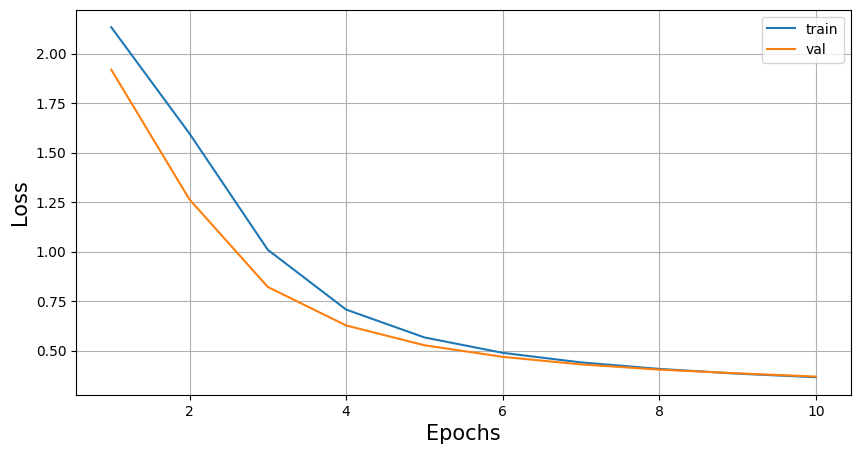

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["val"], label="val")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid()
plt.show()

### Сохранение и загрузка весов модели

Обычно обучение модели является достаточно затратным процессом с точки зрения вычислительных ресурсов. Поэтому однажды обученную сеть разумно будет сохранить для последующего использования. Рассмотрим варианты, как это можно сделать в PyTorch.

Модели PyTorch хранят обучаемые параметры во внутреннем словаре состояния, который называется `state_dict`. Их можно сохранить с помощью метода `torch.save`.


In [ ]:
torch.save(model.state_dict(), "model_weights.pth")

Для того, чтобы загрузить веса модели, сперва необходимо создать экземпляр такой модели, а затем загрузить параметры с помощью метода `load_state_dict()`.

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model_weights.pth", weights_only=True))
model.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


Данный способ сохранения модели подходит только для случая, когда в дальнейшем не предполагается продолжать обучать модель. Для продолжения обучения также необходимо как минимум сохранять состояние оптимизатора.

[[doc] 🛠️ О более общем сохранении состояний модели, оптимизатора и других объектов](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training)

Сохранение в общем случае может выглядеть так:

```python
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': loss_history,
            ...
            }, PATH)
```



###  Предсказания обученной модели

Поэтапно пропустим тестовые изображения через модель и визуализируем результат:

In [ ]:
# get batch
imgs, labels = next(iter(test_dataloader))
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([64, 1, 28, 28])


In [ ]:
# get output
pred = model(imgs.to(device))
print("pred shape: ", pred.shape)

pred shape:  torch.Size([64, 10])


In [ ]:
import numpy as np

pred = pred[:10].detach()
print("Prediction(1 sample):\n", pred[0])

digits = np.argmax(pred.cpu().numpy(), axis=1)
print("Predicted class: ", digits[0])

Prediction(1 sample):
 tensor([-0.8983, -2.9739, -1.2876,  1.4858, -1.5675, -0.5005, -4.5795,  8.2462,
        -0.8598,  3.0954])
Predicted class:  7


In [ ]:
# remove axis
imgs = torch.squeeze(imgs)
print("imgs shape (after squeeze): ", imgs.shape)

# take 10 first images
imgs = imgs[:10]
print("imgs shape: ", imgs.shape)

imgs shape (after squeeze):  torch.Size([64, 28, 28])
imgs shape:  torch.Size([10, 28, 28])


Визуализируем изображения, подпишем предсказанное и истинное значение:

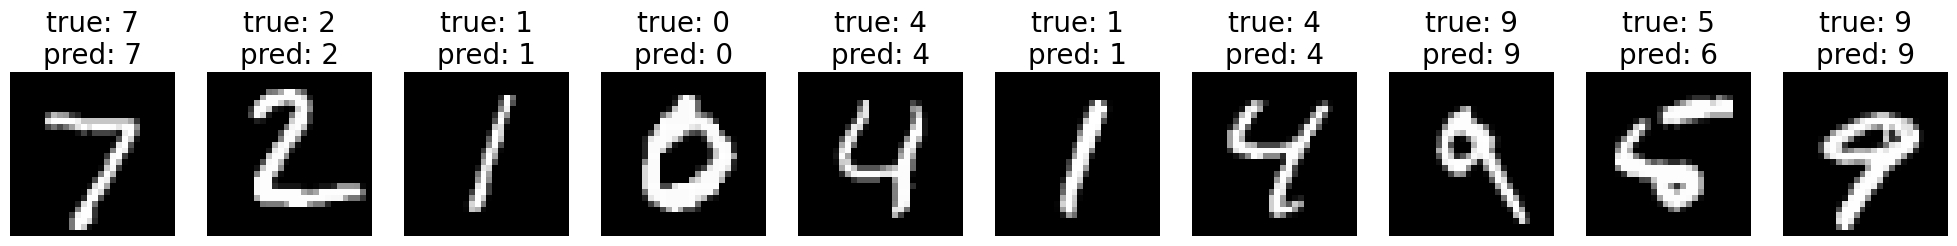

In [ ]:
plt.figure(figsize=(25.0, 25.0))
for i in range(10):
    img = imgs[i]

    plt.subplot(1, 10, i + 1)
    plt.title(
        f"true: {labels[i].numpy()}\npred: {digits[i]}", fontsize=20
    )  # predicted and real values
    plt.axis("off")
    plt.imshow(img.numpy(), cmap="gray")